In [8]:
# Load a full run (model + predictor + loaders + splits) for evaluation
import os, sys, torch
from torch_geometric.transforms import ToUndirected

PROJECT_ROOT = os.path.abspath("..")  # if notebook is in notebooks/
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.load_graph_data import load_hetero_pt
from src.model_io import load_full_run

# Device selection (prefer CUDA; fall back to CPU to avoid MPS sampler issues)
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    # MPS missing CSR conversion for LinkNeighborLoader; use CPU for reliability
    os.environ.setdefault('PYTORCH_ENABLE_MPS_FALLBACK', '1')
    DEVICE = torch.device("cpu")
print('Using device:', DEVICE)

MODEL_SAVE_NAME = 'best_model.pt'

# Load and preprocess data (keep consistent with training)
data = load_hetero_pt()
data = ToUndirected()(data)

# Optional: drop nodes/edges to mirror training pipeline
# Which node types do we want to KEEP in the graph?
keep = ['email', 'url', 'sender', 'domain', 'receiver', 'stem']   # <- adjust as you like

keep_set = set(keep)

# 1) Delete node types that are NOT in keep
for ntype in list(data.node_types):   # list(...) so we can modify while iterating
    if ntype not in keep_set:
        del data[ntype]

# 2) Delete edge types whose src or dst is NOT in keep
for et in list(data.edge_types):      # et is (src, rel, dst)
    src, rel, dst = et
    if src not in keep_set or dst not in keep_set:
        del data[et]

# Feature normalization (zero mean, unit variance per feature dim)
for ntype in data.node_types:
    if 'x' not in data[ntype]:
        continue
    x = data[ntype].x.float()
    mu = x.mean(dim=0)
    sigma = x.std(dim=0).clamp_min(1e-6)
    data[ntype].x = (x - mu) / sigma

# Load model, predictor, loaders, splits, and checkpoint metadata
model, predictor, loaders, splits, checkpoint = load_full_run(
    data=data,
    device=DEVICE,
    filename=MODEL_SAVE_NAME,
)
print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with val loss {checkpoint['val_loss']:.4f}")


Using device: cpu


/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/load_graph_data.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_l

Loaded checkpoint from epoch 10 with val loss 1.4233


### AUROC / Average Precision
These metrics measure ranking quality for link prediction.
- AUROC: probability a random positive scores higher than a random negative (0.5 = random, 1.0 = perfect).
- Average Precision (AP): area under precision-recall; sensitive to class imbalance.
Higher is better for both; low values indicate the model struggles to separate positives from negatives.


In [9]:
from src.eval_link import collect_scores, topk_eval_with_splits

# AUROC/AP (as before)
scores = collect_scores(DEVICE, model, predictor, loaders['test'])
print("TEST AUROC/AP per relation:")
for et, s in scores.items():
    print(et, s)

# Recall@K with cosine and larger K (easier for many-to-many like movie→actor)
res_k50_cos = topk_eval_with_splits(DEVICE, model, splits, splits['sup_ets'], K=50, use_dot=False)
print("\nRecall@50 (cosine) per relation:")
for et, m in res_k50_cos.items():
    print(et, m)

TEST AUROC/AP per relation:
('email', 'has_url', 'url') {'auroc': 0.9244833816725677, 'ap': 0.9398707111122878}
('url', 'rev_has_url', 'email') {'auroc': 0.9282221867924054, 'ap': 0.9338797665004729}

Recall@50 (cosine) per relation:
('email', 'has_url', 'url') {'recall@K': 0.33366483449935913, 'MRR': 0.23621448874473572, 'K': 50, 'n_eval_sources': 2011}
('url', 'rev_has_url', 'email') {'recall@K': 0.3436830937862396, 'MRR': 0.1999342292547226, 'K': 50, 'n_eval_sources': 1868}


### Embedding Norm Diagnostics
Checks L2 norms of email/url embeddings on the train graph.
- Very small norms can indicate vanishing representations; very large norms can explode training/eval scores.
Use to spot instability or excessive regularization.


In [10]:
from src.embed import embed_with_graph

import torch
h_train = embed_with_graph(DEVICE, model, splits['train_graph'])
email_vecs = h_train['email']
url_vecs = h_train['url']

print("Email embedding L2 norms:")
print(email_vecs.norm(dim=1).mean(), email_vecs.norm(dim=1).max())

print("URL embedding L2 norms:")
print(url_vecs.norm(dim=1).mean(), url_vecs.norm(dim=1).max())

Email embedding L2 norms:
tensor(8.0989) tensor(194.6823)
URL embedding L2 norms:
tensor(19.3812) tensor(579.7043)


### Score Distributions + Qualitative Top-K
Histogram of dot-product scores for held-out positives vs random negatives and a Top-K example.
- Good separation: positive scores cluster higher than negatives. Overlap means the model confuses pairs.
- Top-K list shows whether high-scoring URLs for a sample email include true held-out destinations.


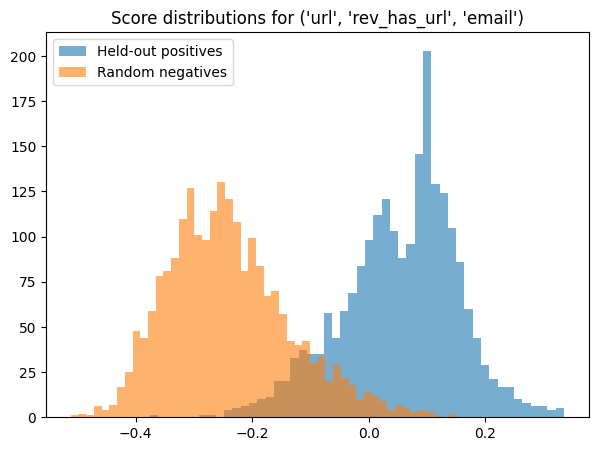

email_id: 1
Top-20 url ids: [2338, 1391, 1392, 1761, 2078, 1638, 1879, 5061, 1785, 3453, 18427, 3531, 17916, 17912, 7205, 13213, 1629, 13951, 4929, 7194]
Is held-out true?: [True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False]


In [11]:
import os, sys
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.embed import embed_with_graph
from src.eval_link import topk_for_source

# --- Embed on the train_graph (leakage-safe) ---
h_train = embed_with_graph(DEVICE, model, splits['train_graph'])

et = ('url', 'rev_has_url', 'email')

# L2-normalize embeddings so dot products ≈ cosine
S = F.normalize(h_train[et[0]], p=2, dim=1)
D = F.normalize(h_train[et[2]], p=2, dim=1)

# For analysis, move everything to CPU to avoid MPS quirks
S = S.cpu()
D = D.cpu()

# Held-out positive edges for this relation (from TEST split)
pos = splits['test_pos'][et]                # [2, E_test]

# Scores for true (held-out) edges
pos_scores = (S[pos[0]] * D[pos[1]]).sum(dim=1).numpy()

# Scores for random negative pairs
g = torch.Generator().manual_seed(0)
neg_src = torch.randint(0, S.size(0), (len(pos_scores),), generator=g)
neg_dst = torch.randint(0, D.size(0), (len(pos_scores),), generator=g)
neg_scores = (S[neg_src] * D[neg_dst]).sum(dim=1).numpy()

plt.figure(figsize=(7, 5))
plt.hist(pos_scores, bins=50, alpha=0.6, label='Held-out positives')
plt.hist(neg_scores, bins=50, alpha=0.6, label='Random negatives')
plt.title(f"Score distributions for {et}")
plt.legend()
plt.show()

# --- Qualitative Top-K example (still fine to use h_train on DEVICE) ---
sources_with_pos = splits['test_pos'][et][0].unique()
src_id = int(sources_with_pos[0])  # pick a valid email id

top_ids, top_scores = topk_for_source(h_train, et, src_id, K=20, cosine=True)
true_dests = set(
    splits['test_pos'][et][1][splits['test_pos'][et][0] == src_id].cpu().tolist()
)
print("email_id:", src_id)
print("Top-20 url ids:", top_ids)
print("Is held-out true?:", [i in true_dests for i in top_ids])


### Recall@K Curves, Dot vs Cosine, and Qualitative Top-K
Evaluates retrieval quality at different K and compares similarity metrics.
- Recall@K: fraction of held-out true destinations retrieved in top-K (higher is better).
- Dot vs cosine highlights sensitivity to vector norms.
- Qualitative Top-K provides an interpretable list for a sample source node.


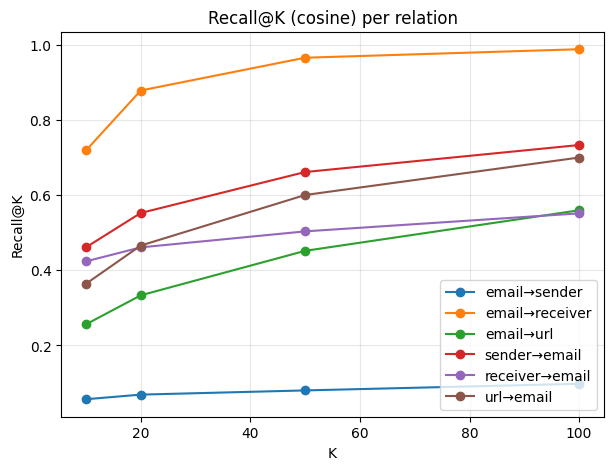


Recall@50: dot vs cosine
('email', 'has_sender', 'sender'): dot=0.069 | cosine=0.080
('email', 'has_receiver', 'receiver'): dot=0.971 | cosine=0.967
('email', 'has_url', 'url'): dot=0.376 | cosine=0.452
('sender', 'rev_has_sender', 'email'): dot=0.617 | cosine=0.662
('receiver', 'rev_has_receiver', 'email'): dot=0.483 | cosine=0.504
('url', 'rev_has_url', 'email'): dot=0.545 | cosine=0.601

Qualitative Top-20 for source email id=24 (cosine):
Top-20 dest ids: [5182, 13077, 12198, 3596, 6201, 12304, 10811, 4541, 696, 12466, 140, 4372, 12199, 4523, 807, 11268, 6177, 5989, 10771, 12980]
Is held-out true?: [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [7]:
# === Light suggestions: recall curves, cosine vs dot, qualitative Top-K, optional fine-tune ===
import torch, matplotlib.pyplot as plt
import os, sys
PROJECT_ROOT = os.path.abspath("..")  # if notebook is in notebooks/
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.embed import embed_with_graph
from src.eval_link import collect_scores, topk_eval_with_splits, topk_for_source, recall_at_k_mrr

# --- 1) Recall@K curves (cosine) ---
K_list = [10, 20, 50, 100]
h_train = embed_with_graph(DEVICE, model, splits['train_graph'])  # leakage-safe embeddings
ets = splits['sup_ets']

recall_curves = {et: [] for et in ets}
for et in ets:
    for K in K_list:
        res = recall_at_k_mrr(h_train, et, splits['test_pos'][et], K=K, use_dot=False)
        recall_curves[et].append(res['recall@K'])

# Plot curves
plt.figure(figsize=(7,5))
for et, vals in recall_curves.items():
    label = f"{et[0]}→{et[2]}"
    plt.plot(K_list, vals, marker='o', label=label)
plt.xlabel("K"); plt.ylabel("Recall@K"); plt.title("Recall@K (cosine) per relation"); plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# --- 2) Dot vs Cosine table at K=50 ---
def recall_at_k_for_metric(h, et, K, use_dot):
    return recall_at_k_mrr(h, et, splits['test_pos'][et], K=K, use_dot=use_dot)['recall@K']

print("\nRecall@50: dot vs cosine")
for et in ets:
    r_dot = recall_at_k_for_metric(h_train, et, K=50, use_dot=True)
    r_cos = recall_at_k_for_metric(h_train, et, K=50, use_dot=False)
    print(f"{et}: dot={r_dot:.3f} | cosine={r_cos:.3f}")

# --- 3) Qualitative Top-K (pick a source that has held-out positives) ---
et_demo = ('email', 'has_url', 'url')  # change if you want a different relation
srcs_with_pos = splits['test_pos'][et_demo][0].unique()
if len(srcs_with_pos) > 0:
    src_id = int(srcs_with_pos[0])  # first valid source
    top_ids, top_scores = topk_for_source(h_train, et_demo, src_id, K=20, cosine=True)
    true_dests = set(splits['test_pos'][et_demo][1][splits['test_pos'][et_demo][0]==src_id].cpu().tolist())
    print(f"\nQualitative Top-20 for source {et_demo[0]} id={src_id} (cosine):")
    print("Top-20 dest ids:", top_ids)
    print("Is held-out true?:", [i in true_dests for i in top_ids])
else:
    print(f"No sources with held-out positives found for {et_demo}")

# --- 4) (Optional) Fine-tune a bit more, then re-run the same checks ---
# Uncomment to do 2 more epochs with same loaders/optimizer settings:
# opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# for e in range(2):
#     tr_loss, tr_acc = train_epoch(model, predictor, opt, loaders['train'])
#     va_loss, va_acc = eval_epoch(model, predictor, loaders['val'])
#     print(f"[Finetune {e+1}/2] train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")
# # Recompute embeddings & recall curves if you fine-tuned:
# # h_train = embed_with_graph(model, splits['train_graph'])
# # (then rerun the recall curve and Top-K blocks above)
